In [38]:
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.patches as patches

from scipy.stats import gaussian_kde as GKDE
from scipy.stats import norm

import src.weightedEDFs as wEDFs
import src.distributionsDCI as distDCI
import src.utils as utils

import matplotlib as mpl

In [39]:
plot_directory = './plots'

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5

CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 
plt.rcParams['image.cmap'] = 'viridis'

## Problem setup

In [40]:
np.random.seed(66)
random.seed(19)

In [41]:
l = 2.
kappa = 1.

In [42]:
N = 100  # Specify the truncation
ts = [1e-4, 1e-2, 1e-1, 0.4, 0.8]
x = np.linspace(0, l, 2*N)

In [43]:
def u_k(k, x, t, l, kappa):
    
    return (2 * l**2 * (-1)**(k+1) / (np.pi * k)
            * np.sin(k * np.pi * x / l)
            * np.exp(-kappa * (k * np.pi)**2 * t) / l**2)

def u(N, x, t, l, kappa):
    
    u_N = 0 * x
    for k in range(1, N):
        u_N += u_k(k, x, t, l, kappa)

    return u_N

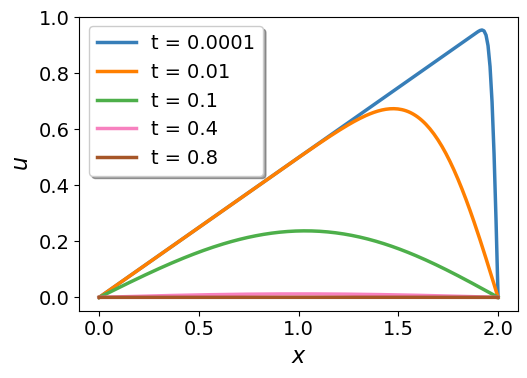

In [44]:
for t in ts:

    u_N = u(N, x, t, l, kappa)
    plt.plot(x, u_N, label='t = ' + str(t));

plt.legend(loc='upper left', shadow=True)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_heat_eq_sol.png', bbox_inches='tight')

In [45]:
ts = [.01]
sensor_loc = 1.2

## Setup the standard DCI problem

In [46]:
n_init_samples = 2000

delta_l = 0.1
delta_kappa = 0.5

init_samples = np.random.uniform(0, 1, (n_init_samples,2))
init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

In [47]:
X = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 100)
Y = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 100)

XX, YY = np.meshgrid(X, Y)
ZZ = np.zeros(np.shape(XX))

for count, x in enumerate(X):
    ZZ[count,:] = u(N, sensor_loc, ts[0], XX[count,:], YY[count,:])

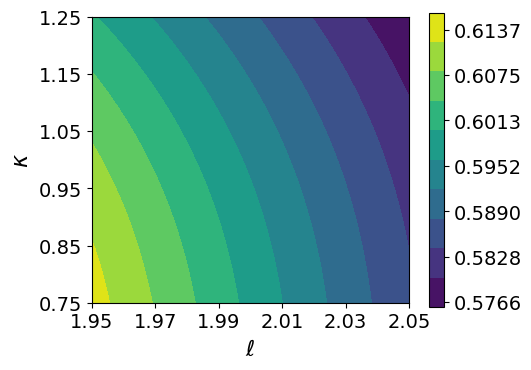

In [48]:
plt.contourf(XX, YY, ZZ, levels=9);
ax = plt.gca()
ax.set_aspect(0.18)

plt.ylabel(r'$\kappa$');
plt.xlabel(r'$\ell$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(ZZ), np.max(ZZ), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(ZZ),
                                                             np.max(ZZ), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_contours.png', bbox_inches='tight')

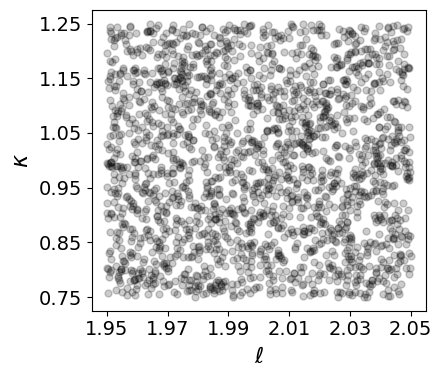

In [49]:
plt.scatter(init_samples[:,0], init_samples[:,1], alpha=0.2, color='k')
ax = plt.gca()
ax.set_aspect(0.18)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_heat_eq_init_samples.png', bbox_inches='tight')

In [50]:
pred_samples = np.zeros((n_init_samples, len(ts)))
for count, t in enumerate(ts):
    pred_samples[:, count] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
    
pred_KDE = GKDE(pred_samples[:,0])

In [51]:
obs_dist = norm(0.595, 3e-3)

n_obs_samples = 10000
obs_samples = obs_dist.rvs(n_obs_samples)

obs_KDE = GKDE(obs_samples)

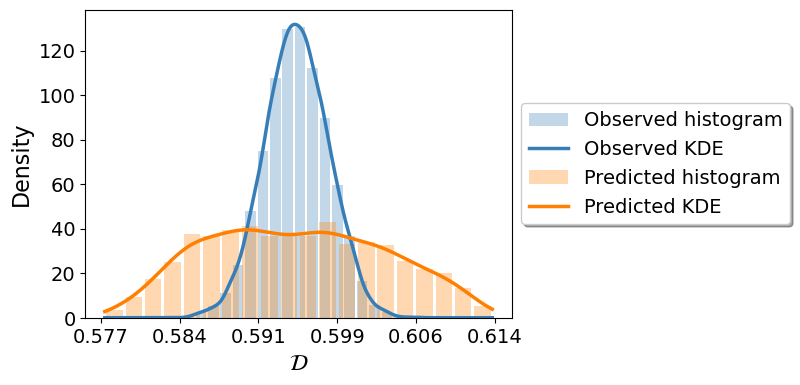

In [52]:
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000)

plt.hist(obs_samples, bins=20, alpha=0.3, density=True, label='Observed histogram', rwidth=0.85);
plt.plot(xx, obs_KDE(xx), color=CB_color_cycle[0], label='Observed KDE')

plt.hist(pred_samples, bins=20, alpha=0.3, density=True, label='Predicted histogram', rwidth=0.85);
plt.plot(xx, pred_KDE(xx), color=CB_color_cycle[1], label='Predicted KDE')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True)
plt.xlabel(r'$\mathcal{D}$')
plt.xticks(ticks=np.linspace(np.min(ZZ), np.max(ZZ), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(ZZ), np.max(ZZ), 6)])
plt.ylabel('Density')

plt.savefig(f'{plot_directory}/heat-equation_demo_heat_eq_dists.png', bbox_inches='tight')

In [53]:
bad_obs_dist = norm(0.613, 7e-3)

n_obs_samples = 10000
bad_obs_samples = bad_obs_dist.rvs(n_obs_samples)

bad_obs_KDE = GKDE(bad_obs_samples)

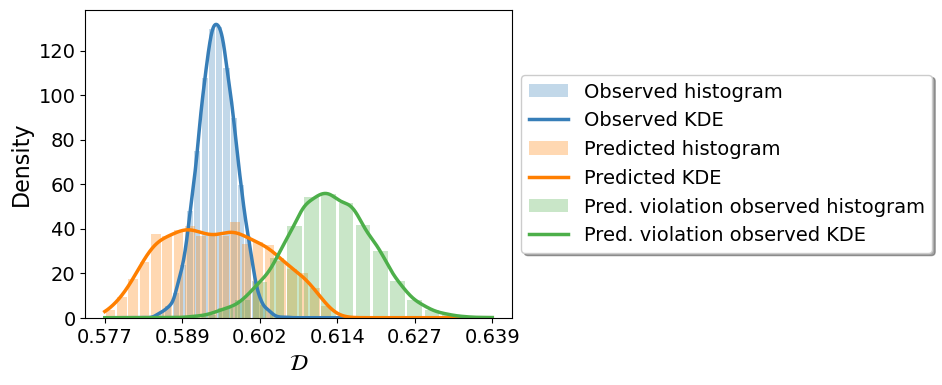

In [54]:
xx = np.linspace(np.min(pred_samples), np.max(bad_obs_samples), 1000)

plt.hist(obs_samples, bins=20, alpha=0.3, density=True, label='Observed histogram', rwidth=0.85);
plt.plot(xx, obs_KDE(xx), color=CB_color_cycle[0], label='Observed KDE')

plt.hist(pred_samples, bins=20, alpha=0.3, density=True, label='Predicted histogram', rwidth=0.85);
plt.plot(xx, pred_KDE(xx), color=CB_color_cycle[1], label='Predicted KDE')

plt.hist(bad_obs_samples, bins=20, alpha=0.3, density=True, label='Pred. violation observed histogram', rwidth=0.85);
plt.plot(xx, bad_obs_KDE(xx), color=CB_color_cycle[2], label='Pred. violation observed KDE')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True)
plt.xlabel(r'$\mathcal{D}$')
plt.xticks(ticks=np.linspace(np.min(pred_samples), np.max(bad_obs_samples), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples), np.max(bad_obs_samples), 6)])
plt.ylabel('Density')

plt.savefig(f'{plot_directory}/heat-equation_demo_heat_eq_dists.png', bbox_inches='tight')

## Density-based solution

In [55]:
r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
rn_w = r / n_init_samples
print(f'E(r) = {np.mean(r)}')

E(r) = 1.0015001051394345


In [56]:
r_bad = bad_obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
print(f'E(r) = {np.mean(r_bad)}')

E(r) = 0.5183618737837757


In [57]:
update_inds = utils.rejection_sampling(r)

update_samples = init_samples[update_inds]

pf_samples = pred_samples[update_inds]

pf_KDE = GKDE(pf_samples.T)

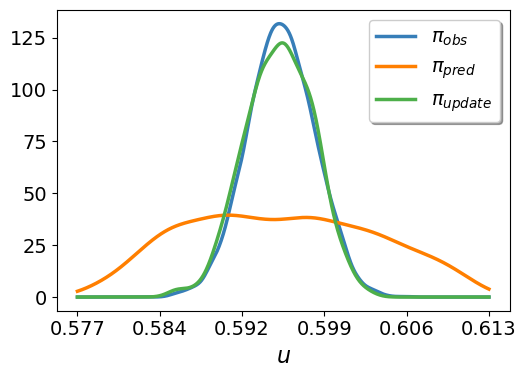

In [26]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$')
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$')
plt.plot(xx, pf_KDE(xx), label=r'$\pi_{update}$')

plt.xticks(ticks=np.linspace(np.min(pred_samples), np.max(pred_samples), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples), np.max(pred_samples), 6)])
plt.xlabel(r'$u$')
plt.legend(shadow=True)

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_dens_results.png', bbox_inches='tight')

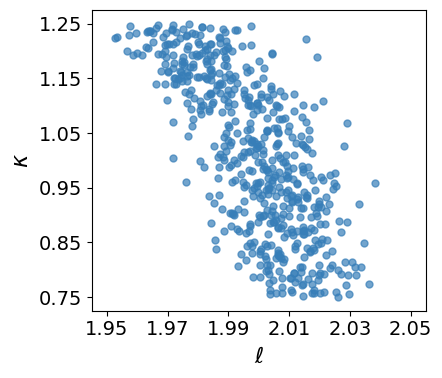

In [27]:
plt.scatter(init_samples[update_inds,0], init_samples[update_inds,1], alpha=0.7)

ax = plt.gca()
ax.set_aspect(0.18)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_rejection.png', bbox_inches='tight')

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_26225/2958563916.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ZZ[ii, jj] = update_KDE([XX[ii,jj],YY[ii,jj]])


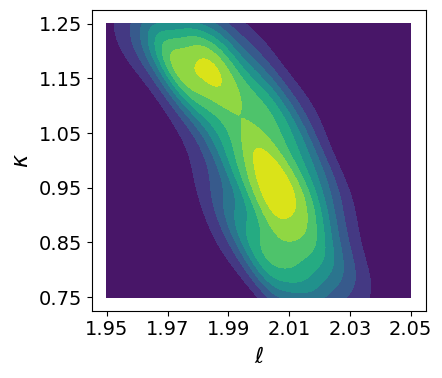

In [28]:
update_KDE = GKDE(update_samples.T)

for ii in range(np.shape(ZZ)[0]):
    for jj in range(np.shape(ZZ)[1]):
        ZZ[ii, jj] = update_KDE([XX[ii,jj],YY[ii,jj]])
plt.contourf(XX, YY, ZZ, levels=10);

ax = plt.gca()
ax.set_aspect(0.18)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_rejection_KDE.png', bbox_inches='tight')

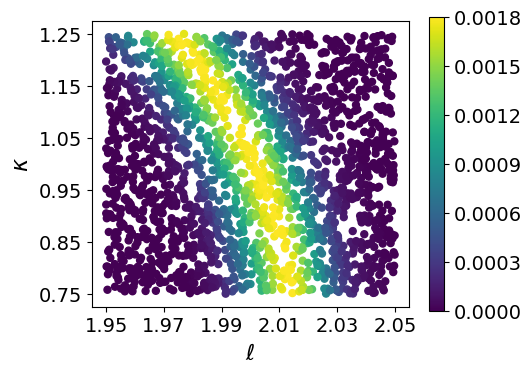

In [29]:
ax = plt.gca()
ax.set_aspect(0.18)

plt.scatter(init_samples[:,0], init_samples[:,1], c=r/n_init_samples)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(r/n_init_samples), np.max(r/n_init_samples), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(r/n_init_samples),
                                                             np.max(r/n_init_samples), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_rn_weights.png', bbox_inches='tight')

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_26225/2112674446.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ZZ[ii, jj] = update_KDE([XX[ii,jj],YY[ii,jj]])


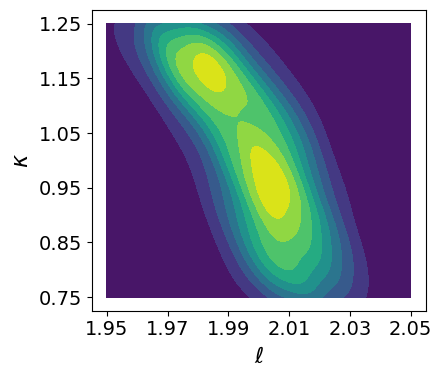

In [30]:
update_KDE = GKDE(init_samples.T, weights=r)

for ii in range(np.shape(ZZ)[0]):
    for jj in range(np.shape(ZZ)[1]):
        ZZ[ii, jj] = update_KDE([XX[ii,jj],YY[ii,jj]])
plt.contourf(XX, YY, ZZ, levels=10);

ax = plt.gca()
ax.set_aspect(0.18)

plt.xlim(1.945, 2.055)
plt.ylim(0.725, 1.275)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_weighted_KDE.png', bbox_inches='tight')

## Naive optimization solution

In [31]:
H = wEDFs.compute_H(np.reshape(pred_samples, (len(pred_samples),1)))
b = wEDFs.compute_b(np.reshape(pred_samples, (len(pred_samples),1)),
                    sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)))
w = wEDFs.compute_optimal_w(H, b)

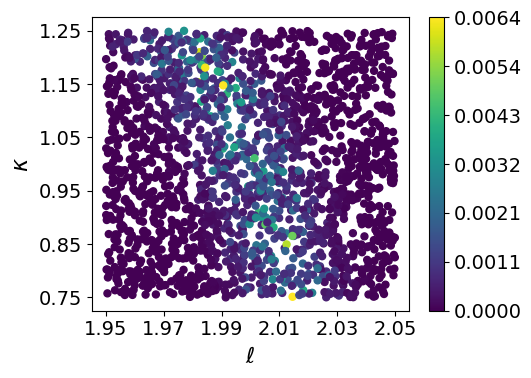

In [32]:
plt.scatter(init_samples[:,0], init_samples[:,1], c=w/n_init_samples)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(w/n_init_samples), np.max(w/n_init_samples), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(w/n_init_samples),
                                                             np.max(w/n_init_samples), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_naive_weights.png', bbox_inches='tight')

## Binning methods

In [33]:
n_bins = 35

### Regular partitioning

In [34]:
rpartitioned_w, bins, centers, w_center = distDCI.computePartitionedWeights_regulargrid_IID(init_samples,
                                                                        pred_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=n_bins)

In [35]:
print(np.sum(rpartitioned_w)/35)

0.02857142857142857


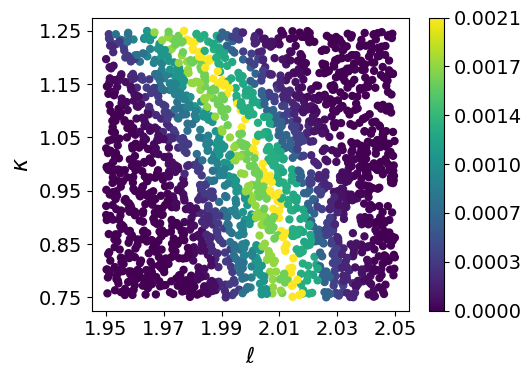

In [36]:
plt.scatter(init_samples[:,0], init_samples[:,1], c=rpartitioned_w)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(rpartitioned_w),
                                                             np.max(rpartitioned_w), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_regpart_weights.png', bbox_inches='tight')

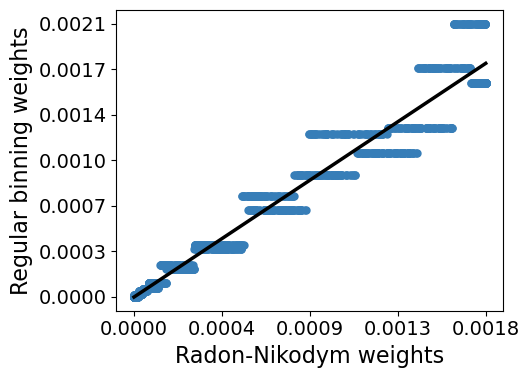

In [37]:
plt.scatter(rn_w, rpartitioned_w)
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k')

plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 5),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 5)])
plt.yticks(ticks=np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7)])
plt.xlabel('Radon-Nikodym weights')
plt.ylabel('Regular binning weights')

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_rn_vs_regpart.png', bbox_inches='tight')

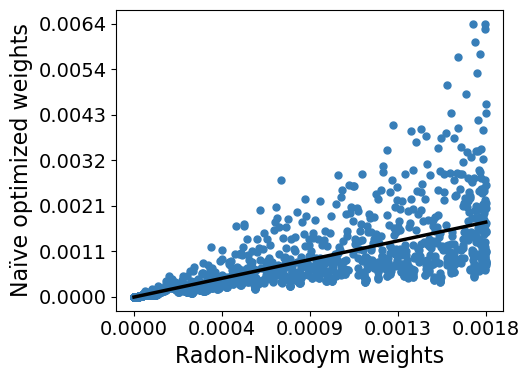

In [34]:
plt.scatter(rn_w, w/n_init_samples)
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k')

plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 5),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 5)])
plt.yticks(ticks=np.linspace(np.min(w/n_init_samples), np.max(w/n_init_samples), 7),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(w/n_init_samples), np.max(w/n_init_samples), 7)])
plt.xlabel('Radon-Nikodym weights')
plt.ylabel('Naïve optimized weights')

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_rn_vs_naive.png')

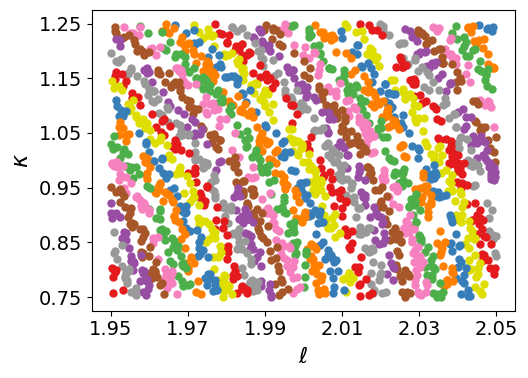

In [35]:
for i in range(n_bins):
    plt.scatter(init_samples[(bins==i),0],init_samples[(bins==i),1])

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_regpart_cells.png', bbox_inches='tight')

### K-means partitioning

In [36]:
kpartitioned_w, clusters, centers, w_center = distDCI.computePartitionedWeights_kMeans_IID(init_samples,
                                                                        pred_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_clusters=n_bins)

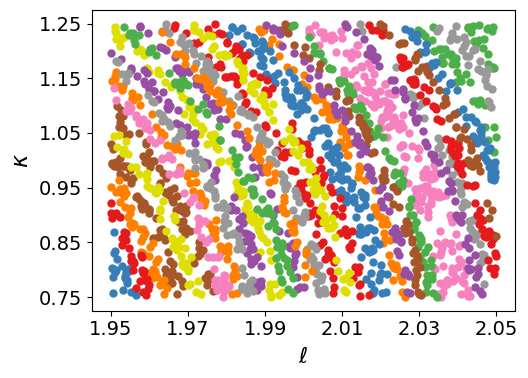

In [37]:
for i in range(n_bins):
    plt.scatter(init_samples[(clusters==i),0], init_samples[(clusters==i),1])

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')

plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_kmeans_part_cells.png', bbox_inches='tight')

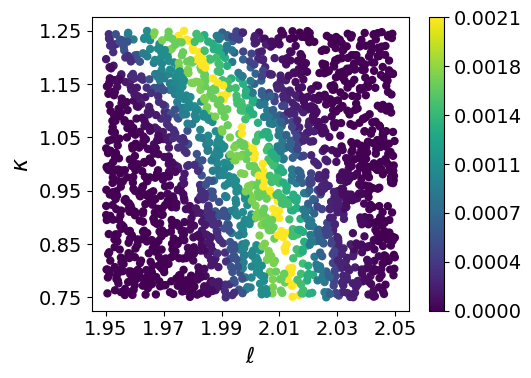

In [38]:
plt.scatter(init_samples[:,0], init_samples[:,1], c=kpartitioned_w)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(kpartitioned_w),
                                                             np.max(kpartitioned_w), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_kmeans_part_weights.png', bbox_inches='tight')

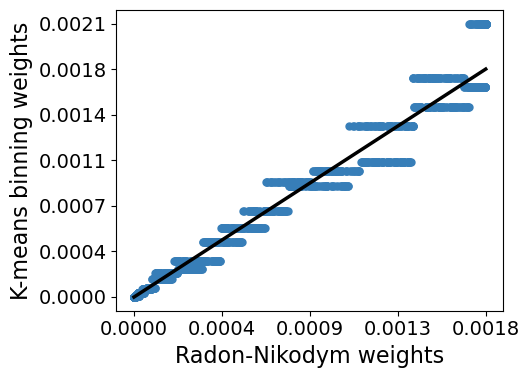

In [39]:
plt.scatter(rn_w, kpartitioned_w)
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k')

plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 5),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 5)])
plt.yticks(ticks=np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7)])
plt.xlabel('Radon-Nikodym weights')
plt.ylabel('K-means binning weights')

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_rn_vs_kmeans_part.png')

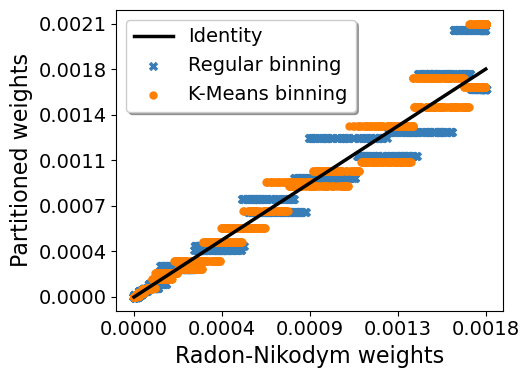

In [40]:
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k', label='Identity')
plt.scatter(rn_w, rpartitioned_w, label='Regular binning', marker='x')

plt.xlabel('Radon-Nikodym weights')
plt.ylabel('Partitioned weights')
plt.scatter(rn_w, kpartitioned_w, label='K-Means binning')
plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 5),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 5)])
plt.yticks(ticks=np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7)])
plt.legend(shadow=True)

plt.tight_layout()
plt.savefig(f'{plot_directory}/heat-equation_demo_regpart_vs_kmeans.png')